In [256]:

# below is the method using degree heuristic to let MST pick higher-degree nodes

import networkx as nx
from parse import read_input_file, write_output_file, read_output_file
import utils
from utils import is_valid_network, average_pairwise_distance, average_pairwise_distance_fast
import os
import sys
import matplotlib.pyplot as plt
import random
import numpy as np
import itertools


def bruteforce(G):
    list_of_trees = []
    min_dist = 1000000
    minT = nx.Graph()
    # Remove degree 1 nodes and add their neighbors to minT
    def traverse(T, G, G_copy):
        nonlocal min_dist
        nonlocal minT
        if G_copy.number_of_edges() == 0:
            return
        for e in G_copy.edges():
            u, v = e[0], e[1]
            if e in T.edges():
                continue
            copy = T.copy()
            temp = G_copy.copy()
            T.add_node(u)
            T.add_node(v)
            T.add_edge(v, u, weight= G[v][u]['weight'])
            temp.remove_edge(u, v)
            if is_valid_network(G, T):
                if average_pairwise_distance_fast(T) < min_dist:
                    min_dist = average_pairwise_distance_fast(T)
                    minT = T.copy()
                traverse(T, G, temp)
            elif not nx.is_dominating_set(G, T.nodes()) or not nx.is_connected(T):
                traverse(T, G, temp)
            T = copy.copy()

    def findChain(G):
        nonlocal confirmed
        nonlocal T
        nonlocal G_copy
        changed = False
        nodes = [n for n in G.nodes()]
        for v in nodes:
            if G.degree(v) == 1:
                u = list(G.neighbors(v))[0]
                confirmed.append(u)
                T.add_node(u)
                if u in confirmed and v in confirmed:
                    T.add_edge(u, v, weight=G[u][v]['weight'])
                    G_copy.remove_edge(u,v)
                G.remove_node(v)
                changed = True
        if changed:
            findChain(G)

    def remove(copy, G_copy, k):
        nonlocal min_dist
        nonlocal minT
        has_valid = False
        for c in itertools.combinations(G_copy.edges(), k):
            temp = copy.copy()
            for e in c:
                u, v = e[0], e[1]
                if copy.degree(u) == 1:
                    copy.remove_node(u)
                elif copy.degree(v) == 1:
                    copy.remove_node(v)
                else:
                    copy.remove_edge(u, v)
            if is_valid_network(G, copy):
                has_valid = True
                if average_pairwise_distance_fast(copy) < min_dist:
                    min_dist = average_pairwise_distance_fast(copy)
                    minT = copy.copy()
            elif nx.is_dominating_set(G, copy.nodes()) and nx.is_connected(copy):
                has_valid = True
            copy = temp
        if not has_valid:
            return
        remove(copy, G_copy, k+1)
        # if copy.number_of_nodes() == 1:
        #     if is_valid_network(G, copy):
        #         minT = copy
        #     return
        # for e in G_copy.edges():
        #     if e not in copy.edges():
        #         continue
        #     u, v = e[0], e[1]
        #     if copy.degree(u) == 1:
        #         if u in confirmed:
        #             continue
        #         copy.remove_node(u)
        #     elif copy.degree(v) == 1:
        #         if v in confirmed:
        #             continue
        #         copy.remove_node(v)
        #     else:
        #         copy.remove_edge(u, v)
        #     if is_valid_network(G, copy):
        #         if average_pairwise_distance_fast(copy) < min_dist:
        #             min_dist = average_pairwise_distance_fast(copy)
        #             minT = copy.copy()
        #         remove(copy, G_copy)
        #     elif nx.is_dominating_set(G, copy.nodes) and nx.is_connected(copy):
        #         remove(copy, G_copy)
        #     if u not in copy.nodes():
        #         copy.add_node(u)
        #     elif v not in copy.nodes():
        #         copy.add_node(v)
        #     copy.add_edge(u, v, weight=G[u][v]['weight'])

    # minT = min(list_of_trees, key=lambda t: average_pairwise_distance_fast(t))
    confirmed = []
    T = nx.Graph()
    G_copy = G.copy()
    findChain(G.copy())
    if T.number_of_nodes() != 0 and is_valid_network(G, T):
        min_dist = average_pairwise_distance_fast(T)
        minT = T.copy()
    else:
        min_dist = average_pairwise_distance_fast(G)
        minT = G.copy()
    # for v in G.nodes():
    #     if G.degree(v) == 1:
    #         confirmed.append(list(G.neighbors(v))[0])
    #remove(G.copy())
    # T = nx.Graph()
    remove(G.copy(), G_copy, 1)
    return minT



def solve(G):
    """
    Args:
        G: networkx.Graph

    Returns:
        T: networkx.Graph
    """
    def prune(g):
        nonlocal min_T
        copy = g.copy()
        if g.number_of_edges() == 0:
            min_T = g
            return
        e = random.choice(list(g.edges()))
        if copy.degree(e[0]) == 1:
            copy.remove_node(e[0])
        elif copy.degree(e[1]) == 1:
            copy.remove_node(e[1])
        else:
            copy.remove_edge(e[0], e[1])
        if is_valid_network(G, copy):
            d = average_pairwise_distance_fast(copy)
            min_dist = average_pairwise_distance_fast(min_T)
            if d < min_dist:
                min_T = copy.copy()
            prune(copy)
        elif nx.is_connected(copy) and nx.is_dominating_set(G, copy):
            prune(copy)
#     Special case for one central node
    for node in G.nodes():
        if G.degree(node) == G.number_of_nodes() - 1 and not G.has_edge(node, node):
            T = nx.Graph()
            T.add_node(node)
            return T
    # added: weight <- weight - degree, to let MST choose higher-degree nodes
    G_copy = G.copy()
    for edge in G_copy.edges.data():
        u, v = edge[0], edge[1]
        edge[2]['weight'] /= (G_copy.degree(u) + G_copy.degree(v)) / 2
        edge[2]['weight'] *= (nx.eccentricity(G, u) + nx.eccentricity(G,v)) / 2
        edge[2]['weight'] *= random.uniform(0.6, 1.4)
    
#     T = nx.Graph()
#     all_shortest_path_lengths = dict(nx.shortest_path_length(G, weight='weight'))
#     all_shortest_paths = nx.shortest_path(G, weight='weight')
#     average_shortest_path_lengths = {}
#     for v in all_shortest_path_lengths.keys():
#         average_shortest_path_lengths[v] = sum([all_shortest_path_lengths[v][u] for u in G.nodes()]) / (
#                 G.number_of_nodes() - 1)
#     root = min(average_shortest_path_lengths, key=lambda x: average_shortest_path_lengths[x])
#     T.add_node(root)
#     G_copy = G.copy()
#     G_copy.remove_node(root)
#     while not is_valid_network(G, T):
#         average_distances = {}
#         corresponding_edge = {}
#         for node in T.nodes():
#             for adj in G.neighbors(node):
#                 if adj in T.nodes(): continue
#                 if adj not in average_distances.keys():
#                     average_distances[adj] = (sum(
#                         [all_shortest_path_lengths[adj][t] for t in T.nodes()]) / T.number_of_nodes() +
#                                               G[node][adj]['weight'])
#                     corresponding_edge[adj] = (node, adj)
#                 else:
#                     temp = (sum(
#                         [all_shortest_path_lengths[adj][t] for t in T.nodes()]) / T.number_of_nodes() +
#                                               G[node][adj]['weight'])
#                     if average_distances[adj] > temp:
#                         average_distances[adj] = temp
#                         corresponding_edge[adj] = (node, adj)
#         next = min(average_distances.keys(), key=lambda x: average_distances[x])
#         T.add_node(next)
#         G_copy.remove_node(next)
#         T.add_edge(corresponding_edge[next][0], corresponding_edge[next][1],
#                    weight=G[corresponding_edge[next][0]][corresponding_edge[next][1]]['weight'])
        
#     min_T = T.copy()
    
    T = nx.minimum_spanning_tree(G_copy)
    for edge in T.edges.data():
        u, v = edge[0], edge[1]
        edge[2]['weight'] = G[u][v]['weight']
        
    min_T = T.copy()

    if T.number_of_nodes() == 1:
        return T
    elif T.number_of_nodes() == 2:
        node = list(T.nodes)[0]
        T.remove_node(node)
        return T
    else:
        for i in range(100):
            prune(T.copy())
        
        
        
        
        # Add some edges with lower weights
        all_shortest_path_lengths = dict(nx.shortest_path_length(G, weight='weight'))
        all_shortest_paths = nx.shortest_path(G, weight='weight')
        dist = average_pairwise_distance_fast(T)
        for v in G.nodes():
            if nx.eccentricity(G, v, all_shortest_path_lengths):
                T.add_node(v)
                edge_list = [(u, v) for u in T.nodes() if G.has_edge(u, v)]
                r = random.randint(0, len(edge_list))
                edges_to_add = random.sample(edge_list, r)
                for e in edges_to_add:
                    T.add_edge(e[0], e[1], weight=G[e[0]][e[1]]['weight'])
        
                
        for i in range(100):
            copy = min_T.copy()
            while is_valid_network(G, copy):
                T = copy.copy()
                node_list = list(T.nodes())
                edge_weights = sum([G[n][v]['weight'] for v in G.neighbors(n)])
                n = random.choices(node_list, weights=[np.exp(-w) for w in edge_weights])[0]
                copy.remove_node(n)
                if len(list(copy.nodes)) == 0:
                    return T
                if is_valid_network(G, copy):
                    if utils.average_pairwise_distance_fast(copy) < utils.average_pairwise_distance_fast(min_T):
                        min_T = copy.copy()
        #prune(T)
        # added
        #         min_T.remove_edge(20, 21)
        #         min_T.add_edge(13, 17)

        return min_T
        # TODO: your code here!


# Here's an example of how to run your solver.

# Usage: python3 solver.py test.in

if __name__ == '__main__':
#         input_folder_path = 'inputs'
#         for input_file in os.listdir(input_folder_path):
#             print(input_file)
#             full_path = os.path.join(input_folder_path, input_file)
#             G = read_input_file(full_path)
# #             total = sum([1 for n in G.nodes() if G.degree(n) <= 2])
# #             leaves = sum([1 for n in G.nodes() if G.degree(n) < 2])
# #             if total >= 15 and G.number_of_nodes() <= 25 and leaves <= 12:
# #                 T = bruteforce(G)
# #             else:
#             Tree_list = []
#             for i in range(10):
#                 Tree_list.append(solve(G))
#             T = min(Tree_list, key= lambda t: average_pairwise_distance_fast(t))
#             assert is_valid_network(G, T), "T is not a valid network of G."
#             # Compare previous result with new result, update if improvement seen
#             old = read_output_file('outputs/' + input_file[:-2] + 'out', G)
#             dist_old = average_pairwise_distance_fast(old)
#             dist_new = average_pairwise_distance_fast(T)
#             print("Old Average  pairwise distance: {}".format(dist_old))
#             print("New Average  pairwise distance: {}".format(dist_new))
#             if dist_old > dist_new:
#                 write_output_file(T, 'outputs/' + input_file[:-2] + 'out')

    path = 'inputs/large-100.in'
    G = read_input_file(path)
    
    #Added: if more than 15 nodes with degree <= 2
    total = sum([1 for n in G.nodes() if G.degree(n) <= 2])
    leaves = sum([1 for n in G.nodes() if G.degree(n) < 2])
    if total >= 15 and G.number_of_nodes() <= 25 and leaves <= 12:
        T = bruteforce(G)
    else:
        T = solve(G)
    
#     Tree_list = []
#     for i in range(100):
#         Tree_list.append(solve(G))
#     T = min(Tree_list, key= lambda t: average_pairwise_distance_fast(t))
#     T.add_edge(1, 8, weight=G[1][8]['weight'])
    
    fig = plt.figure(figsize=(20, 30))
    fig.add_subplot(211)
    pos = nx.spring_layout(G)

    labels = nx.get_edge_attributes(G, 'weight')

    nx.draw_networkx(G, pos=pos, node_color='yellow')
    nx.draw_networkx(G.edge_subgraph(T.edges()), pos=pos, node_color='red', edge_color='red')
    #nx.draw_networkx(T, pos=pos, node_color='blue')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    assert is_valid_network(G, T), "T is not a valid network of G."
    # Compare previous result with new result, update if improvement seen
    old = read_output_file('outputs/' + path[7:-2] + 'out', G)
    dist_old = average_pairwise_distance_fast(old)
    dist_new = average_pairwise_distance_fast(T)
    print("Old Average  pairwise distance: {}".format(dist_old))
    print("New Average  pairwise distance: {}".format(dist_new))
    if dist_old > dist_new:
        write_output_file(T, 'outputs/' + path[7:-2] + 'out')



        




UnboundLocalError: local variable 'n' referenced before assignment

In [102]:

import networkx as nx
from parse import read_input_file, write_output_file, read_output_file
import utils
from utils import is_valid_network, average_pairwise_distance, average_pairwise_distance_fast
import os
import sys
import matplotlib.pyplot as plt
import random
import numpy as np
from parse import read_input_file, write_output_file, read_output_file
# path = 'inputs/small-1.in'
# G = read_input_file(path)
# #T = read_output_file(path, G)
# T = nx.Graph()
# all_shortest_path_lengths = dict(nx.shortest_path_length(G, weight='weight'))
# all_shortest_paths = nx.shortest_path(G, weight='weight')
# average_shortest_path_lengths = {}
# for v in all_shortest_path_lengths.keys():
#     average_shortest_path_lengths[v] = sum([all_shortest_path_lengths[v][u] for u in G.nodes()]) / (
#             G.number_of_nodes() - 1)
# root = min(average_shortest_path_lengths, key=lambda x: average_shortest_path_lengths[x])
# T.add_node(root)
# G_copy = G.copy()
# G_copy.remove_node(root)
# while not is_valid_network(G, T):
#     average_distances = {}
#     corresponding_edge = {}
#     for node in T.nodes():
#         for adj in G.neighbors(node):
#             if adj in T.nodes(): continue
#             if adj not in average_distances.keys():
#                 average_distances[adj] = (sum(
#                     [all_shortest_path_lengths[adj][t] for t in G_copy.nodes()]) / G_copy.number_of_nodes() +
#                                           G[node][adj]['weight'])
#                 corresponding_edge[adj] = (node, adj)
#             else:
#                 temp = (sum(
#                     [all_shortest_path_lengths[adj][t] for t in G_copy.nodes()]) / G_copy.number_of_nodes() +
#                                           G[node][adj]['weight'])
#                 if average_distances[adj] > temp:
#                     average_distances[adj] = temp
#                     corresponding_edge[adj] = (node, adj)
#     next = min(average_distances.keys(), key=lambda x: average_distances[x])
#     T.add_node(next)
#     G_copy.remove_node(next)
#     T.add_edge(corresponding_edge[next][0], corresponding_edge[next][1],
#                weight=G[corresponding_edge[next][0]][corresponding_edge[next][1]]['weight'])

# fig = plt.figure(figsize=(20, 30))
# fig.add_subplot(211)
# pos = nx.spring_layout(G)

# labels = nx.get_edge_attributes(G, 'weight')

# nx.draw_networkx(G, pos=pos, node_color='yellow')
# nx.draw_networkx(G.edge_subgraph(T.edges()), pos=pos, node_color='red', edge_color='red')
# #nx.draw_networkx(T, pos=pos, node_color='blue')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# assert is_valid_network(G, T), "T is not a valid network of G."

# print("Average  pairwise distance: {}".format(average_pairwise_distance(T)))
# write_output_file(T, 'outputs/' + path[7:-2] + 'out')

input_folder_path = 'inputs'
for input_file in os.listdir(input_folder_path):
    print(input_file)
    full_path = os.path.join(input_folder_path, input_file)
    G = read_input_file(full_path)
    T = nx.Graph()
    all_shortest_path_lengths = dict(nx.shortest_path_length(G, weight='weight'))
    all_shortest_paths = nx.shortest_path(G, weight='weight')
    average_shortest_path_lengths = {}
    for v in all_shortest_path_lengths.keys():
        average_shortest_path_lengths[v] = sum([all_shortest_path_lengths[v][u] for u in G.nodes()]) / (
                G.number_of_nodes() - 1)
    root = min(average_shortest_path_lengths, key=lambda x: average_shortest_path_lengths[x])
    T.add_node(root)
    G_copy = G.copy()
    G_copy.remove_node(root)
    while not is_valid_network(G, T):
        average_distances = {}
        corresponding_edge = {}
        for node in T.nodes():
            for adj in G.neighbors(node):
                if adj in T.nodes(): continue
                if adj not in average_distances.keys():
                    average_distances[adj] = (sum(
                        [all_shortest_path_lengths[adj][t] for t in G_copy.nodes()]) / G_copy.number_of_nodes() +
                                              G[node][adj]['weight'])
                    corresponding_edge[adj] = (node, adj)
                else:
                    temp = (sum(
                        [all_shortest_path_lengths[adj][t] for t in G_copy.nodes()]) / G_copy.number_of_nodes() +
                                              G[node][adj]['weight'])
                    if average_distances[adj] > temp:
                        average_distances[adj] = temp
                        corresponding_edge[adj] = (node, adj)
        next = min(average_distances.keys(), key=lambda x: average_distances[x])
        T.add_node(next)
        G_copy.remove_node(next)
        T.add_edge(corresponding_edge[next][0], corresponding_edge[next][1],
                   weight=G[corresponding_edge[next][0]][corresponding_edge[next][1]]['weight'])
    all_shortest_path_lengths = dict(nx.shortest_path_length(G, weight='weight'))
    all_shortest_paths = nx.shortest_path(G, weight='weight')
    dist = average_pairwise_distance_fast(T)
    min_T = T.copy()
    for v in G.nodes():
        if nx.eccentricity(G, v, all_shortest_path_lengths):
            T.add_node(v)
            edge_list = [(u, v) for u in T.nodes() if G.has_edge(u, v)]
            r = random.randint(0, len(edge_list))
            edges_to_add = random.sample(edge_list, r)
            for e in edges_to_add:
                T.add_edge(e[0], e[1], weight=G[e[0]][e[1]]['weight'])
    
    for i in range(300):
        copy = T.copy()
        while is_valid_network(G, copy):
            T = copy.copy()
            node_list = list(T.nodes())
            n = random.choices(node_list)[0]
            copy.remove_node(n)
            if len(list(copy.nodes)) == 0:
                min_T = T.copy()
                break
            if is_valid_network(G, copy):
                if utils.average_pairwise_distance_fast(copy) < utils.average_pairwise_distance_fast(min_T):
                    min_T = copy.copy()
                    
    T = min_T.copy()
    assert is_valid_network(G, T), "T is not a valid network of G."
    # Compare previous result with new result, update if improvement seen
    old = read_output_file('outputs/' + input_file[:-2] + 'out', G)
    dist_old = average_pairwise_distance_fast(old)
    dist_new = average_pairwise_distance_fast(T)
    print("Old Average  pairwise distance: {}".format(dist_old))
    print("New Average  pairwise distance: {}".format(dist_new))
    if dist_old > dist_new:
        write_output_file(T, 'outputs/' + input_file[:-2] + 'out')


large-1.in
Old Average  pairwise distance: 60.40533562822719
New Average  pairwise distance: 69.14715719063545
large-10.in
Old Average  pairwise distance: 2.0167619047619048
New Average  pairwise distance: 2.0167619047619048
large-100.in
Old Average  pairwise distance: 28.773913043478263
New Average  pairwise distance: 28.773913043478263
large-101.in
Old Average  pairwise distance: 25.975088652482267
New Average  pairwise distance: 32.007501512401696
large-102.in
Old Average  pairwise distance: 0
New Average  pairwise distance: 11.527665317139002
large-103.in


KeyboardInterrupt: 

Average  pairwise distance: 104.90535238095238


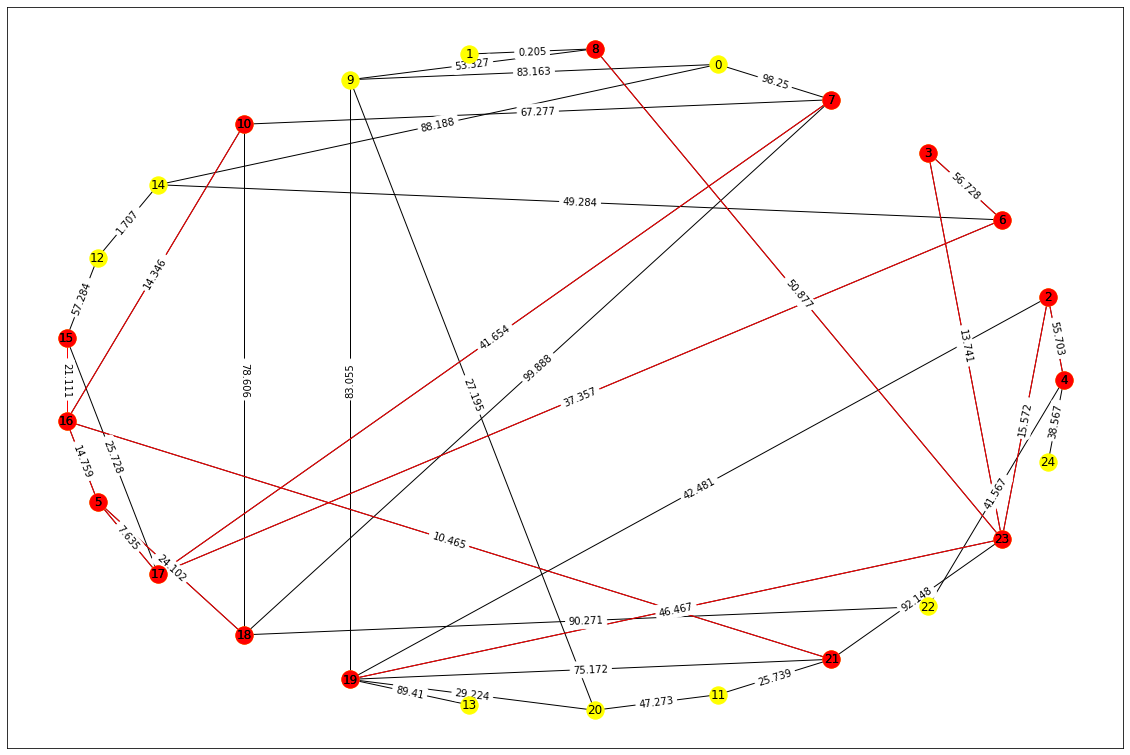

In [238]:
import networkx as nx
from parse import read_input_file, write_output_file, read_output_file
import utils
from utils import is_valid_network, average_pairwise_distance, average_pairwise_distance_fast
import os
import sys
import matplotlib.pyplot as plt
import random
import numpy as np
from parse import read_input_file, write_output_file, read_output_file
path = 'outputs/small-136.out'
G = read_input_file('inputs/small-136.in')
T = read_output_file(path, G)

fig = plt.figure(figsize=(20, 30))
fig.add_subplot(211)
pos = nx.circular_layout(G)

labels = nx.get_edge_attributes(G, 'weight')

nx.draw_networkx(G, pos=pos, node_color='yellow')
nx.draw_networkx(G.edge_subgraph(T.edges()), pos=pos, node_color='red', edge_color='red')
#nx.draw_networkx(T, pos=pos, node_color='blue')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
assert is_valid_network(G, T), "T is not a valid network of G."

print("Average  pairwise distance: {}".format(average_pairwise_distance(T)))